In [1]:
# 크롤러를 만들기 전 필요한 도구들을 임포트
import requests
import pandas as pd
from bs4 import BeautifulSoup

# 입력값 : 페이지 수, 카테고리, 날짜
def make_urllist(page_num, code, date): 
  urllist= []
  for i in range(1, page_num + 1):
    url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)
    headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.90 Safari/537.36'}
    news = requests.get(url, headers=headers)

    # BeautifulSoup의 인스턴스 생성합니다. 파서는 html.parser를 사용합니다.
    soup = BeautifulSoup(news.content, 'html.parser')

    # CASE 1
    news_list = soup.select('.newsflash_body .type06_headline li dl')
    # CASE 2
    news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
    # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만
    for line in news_list:
        urllist.append(line.a.get('href'))
  return urllist

In [2]:
idx2word = {'100' : '정치', '101' : '경제', '102' : '사회', '103' : '생활/문화', '104' : '세계','105' : 'IT/과학'}

In [8]:
from newspaper import Article

#- 데이터프레임을 생성하는 함수
def make_data(urllist, code):
  text_list = []
  for url in urllist:
    article = Article(url, language='ko')
    try:
        article.download()
    except ArticleException:
        continue
    article.parse()
    text_list.append(article.title)

  #- 데이터프레임 'news' 키 아래 파싱한 텍스트를 밸류로 지정
  df = pd.DataFrame({'news': text_list})

  #- 데이터프레임의 'code' 키 아래 한글 카테고리명
  df['code'] = idx2word[str(code)]
  return df

In [9]:
code_list = [100, 101, 103, 105]

In [10]:
# 코드 리스트, 날짜, 페이지 수 입력받는 함수
def make_total_data(page_num, code_list, date):
  df = None

  for code in code_list:
    url_list = make_urllist(page_num, code, date)
    df_temp = make_data(url_list, code)
    print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')

    if df is not None:
      df = pd.concat([df, df_temp])
    else:
      df = df_temp

  return df

In [11]:
df = make_total_data(50, code_list, 20240103)

100번 코드에 대한 데이터를 만들었습니다.
101번 코드에 대한 데이터를 만들었습니다.
103번 코드에 대한 데이터를 만들었습니다.
105번 코드에 대한 데이터를 만들었습니다.


In [12]:
import os

# 데이터프레임 파일을 csv 파일로 저장합니다.
# 저장경로는 이번 프로젝트를 위해 만든 폴더로 지정해 주세요.
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data(x50).csv"
df.to_csv(csv_path, index=False)

if os.path.exists(csv_path):
  print('{} File Saved!'.format(csv_path))

/aiffel/aiffel/news_crawler/news_data(x50).csv File Saved!


In [13]:
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data(x50).csv"
df = pd.read_table(csv_path, sep=',')

In [14]:
print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  4000


In [15]:
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
df['news']

0                         이재명 대표 급습 피의자 구속영장 청구일 실질심사종합
1                                 라오스서 사륜구동 타던 한국인 명 숨져
2                       민주당 국민의힘이재명 테러범 출신 놓고 총선 수싸움 치열
3                                   하반기부터 입영대상자 전원 마약검사
4                       민주 피습 대책 마련 비상 의원총회한동훈 신년인사회 참석
                             ...                       
3995    세종텔레콤 광물자원 활용  발행 플랫폼 구축 및 유통 시스템 연계 기술검증 사업 성료
3996                         애플 에 세계 위 내주나 시총 억 달러 증발 왜
3997                                   중심 삼성현대차 새 기술 공개
3998                     애플 주가 새해 첫 거래일 뚝좁혀진 시총 위 와의 격차
3999                              테슬라 리비안 니콜라  전기차 일제종합
Name: news, Length: 4000, dtype: object

In [16]:
print(df.isnull().sum())
# 있으면 지우기
df = df.dropna()
print(df.isnull().sum())

news    9
code    0
dtype: int64
news    0
code    0
dtype: int64


In [17]:
df.drop_duplicates(subset=['news'], inplace=True)
print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  3580


    code  count
0  IT/과학    894
1     경제    921
2  생활/문화    904
3     정치    861


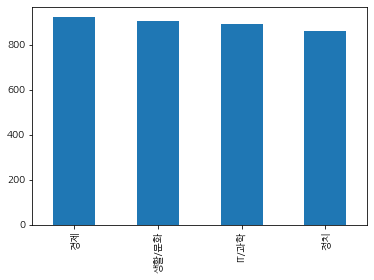

In [18]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "NanumGothic"

df['code'].value_counts().plot(kind = 'bar')
print(df.groupby('code').size().reset_index(name = 'count'))

In [26]:
from konlpy.tag import Mecab
tokenizer = Mecab()

In [27]:
stopwords = ["으로", "은", "는", "ㄴ", "이", "가", "하", "것", "ㅁ", "ㄹ",
             "어", "등", "도", "었", "겠", "만", "와", "과", "의", "에",
             "아니", "없", "되", "로", "며", "지", "언급", "위", "때문", "로",
             "기", "를", "찾", "곳", "어야", "김", "습니다", "다", "ㄴ다", "만들"]

In [28]:
def preprocessing(data):
    text_data = []

    for sentence in data:
        try:
            temp_data = []
            #- 토큰화
            temp_data = tokenizer.morphs(sentence)
            #- 불용어 제거
            temp_data = [word for word in temp_data if word not in stopwords]
            text_data.append(temp_data)
        except Exception as e:
            print(f"전처리 중 오류 발생: {e}")
            print(f"오류가 발생한 문장: {sentence}")

    text_data = list(map(' '.join, text_data))

    return text_data

In [29]:
len(df['news'])

3580

In [30]:
text_data = preprocessing(df['news'])
print(text_data[0])

이재명 대표 급습 피의자 구속영장 청구 일 실질 심사 종합


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df['news'].values, df['code'].values, random_state=0)

In [33]:
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

훈련용 뉴스 기사의 개수 : 2685
테스트용 뉴스 기사의 개수 :  895
훈련용 레이블의 개수 :  2685
테스트용 레이블의 개수 :  895


In [34]:
len(df['news'])

3580

In [35]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [36]:
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

In [37]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.66      0.74      0.70       233
          경제       0.67      0.59      0.63       234
       생활/문화       0.70      0.70      0.70       206
          정치       0.87      0.88      0.87       222

    accuracy                           0.73       895
   macro avg       0.73      0.73      0.72       895
weighted avg       0.72      0.73      0.72       895



In [43]:
# for i in range(100, 200):
#     print(tokenizer.morphs(text_data[i]))
stopwords = ["으로", "은", "는", "던", "이", "가", "하", "것", "수", "한",
             "어", "등", "도", "었", "겠", "만", "와", "과", "의", "에",
             "아니", "없", "되", "로", "며", "지", "언급", "위", "때문", "로",
             "기", "을", "를", "찾", "곳", "어야", "김", "습니다", "다", "낳",
             "만들", "러", "엥", "명", "외", "또", "준비", "제시", "고", "님", "한다"]

In [44]:
def preprocessing(data):
    text_data = []

    for sentence in data:
        try:
            temp_data = []
            #- 토큰화
            temp_data = tokenizer.morphs(sentence)
            #- 불용어 제거
            temp_data = [word for word in temp_data if word not in stopwords]
            text_data.append(temp_data)
        except Exception as e:
            print(f"전처리 중 오류 발생: {e}")
            print(f"오류가 발생한 문장: {sentence}")

    text_data = list(map(' '.join, text_data))

    return text_data

In [45]:
X_train, X_test, y_train, y_test = train_test_split(df['news'].values, df['code'].values, random_state=0)
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

훈련용 뉴스 기사의 개수 : 2685
테스트용 뉴스 기사의 개수 :  895
훈련용 레이블의 개수 :  2685
테스트용 레이블의 개수 :  895


In [46]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.66      0.74      0.70       233
          경제       0.67      0.59      0.63       234
       생활/문화       0.70      0.70      0.70       206
          정치       0.87      0.88      0.87       222

    accuracy                           0.73       895
   macro avg       0.73      0.73      0.72       895
weighted avg       0.72      0.73      0.72       895



In [47]:
# 새로운 날짜의 데이터 추가 함수
def add_new_date_data(page_num, code_list, new_date):
    # 기존 데이터프레임 불러오기
    existing_df = pd.read_csv('news_data(x50).csv')  # 현재 파일명

    # 새로운 날짜의 데이터 수집 및 추가
    for code in code_list:
        url_list = make_urllist(page_num, code, new_date)
        df_temp = make_data(url_list, code)
        print(str(code)+'번 코드에 대한 데이터를 추가했습니다.')

        existing_df = pd.concat([existing_df, df_temp])

    # 새로운 데이터를 추가한 데이터프레임을 저장
    existing_df.to_csv('news_data(x50)_.csv', index=False)

In [48]:
code_list = [100, 101, 103, 105]
add_new_date_data(20, code_list, 20240105)

100번 코드에 대한 데이터를 추가했습니다.
101번 코드에 대한 데이터를 추가했습니다.
103번 코드에 대한 데이터를 추가했습니다.
105번 코드에 대한 데이터를 추가했습니다.


In [49]:
print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  3580


In [50]:
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data(x50)_.csv"
df = pd.read_table(csv_path, sep=',')

In [51]:
print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  5600


In [52]:
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
df['news']

0          이재명 대표 급습 피의자 구속영장 청구일 실질심사종합
1                  라오스서 사륜구동 타던 한국인 명 숨져
2        민주당 국민의힘이재명 테러범 출신 놓고 총선 수싸움 치열
3                    하반기부터 입영대상자 전원 마약검사
4        민주 피습 대책 마련 비상 의원총회한동훈 신년인사회 참석
                      ...               
5595      한컴 클립소프트 인수디지털 데이터 사업 진출 시장 공략
5596    모두가 비트코인 에 예라고 할 때 아니오 외쳤더니엠블록레터
5597             게시판 바이오사이언스   등급한 단계 상승
5598             동아 스텔라라 바이오시밀러  품목허가 신청
5599          비트코인 현물  출시 허가 일에 결정 의 선택은
Name: news, Length: 5600, dtype: object

In [53]:
print(df.isnull().sum())
# 있으면 지우기
df = df.dropna()
print(df.isnull().sum())

news    14
code     0
dtype: int64
news    0
code    0
dtype: int64


In [54]:
df.drop_duplicates(subset=['news'], inplace=True)
print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  5063


    code  count
0  IT/과학   1264
1     경제   1289
2  생활/문화   1282
3     정치   1228


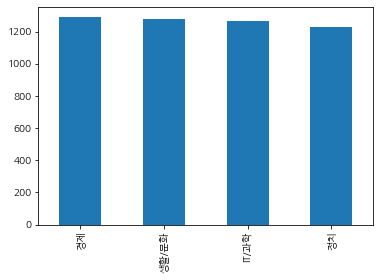

In [55]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "NanumGothic"

df['code'].value_counts().plot(kind = 'bar')
print(df.groupby('code').size().reset_index(name = 'count'))

In [56]:
def preprocessing(data):
    text_data = []

    for sentence in data:
        try:
            temp_data = []
            #- 토큰화
            temp_data = tokenizer.morphs(sentence)
            #- 불용어 제거
            temp_data = [word for word in temp_data if word not in stopwords]
            text_data.append(temp_data)
        except Exception as e:
            print(f"전처리 중 오류 발생: {e}")
            print(f"오류가 발생한 문장: {sentence}")

    text_data = list(map(' '.join, text_data))

    return text_data

In [57]:
text_data = preprocessing(df['news'])
print(text_data[100])

월 총선 앞두 대통령실 국민 소통 여론 조사 예산 증액


In [58]:
X_train, X_test, y_train, y_test = train_test_split(df['news'].values, df['code'].values, random_state=0)
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

훈련용 뉴스 기사의 개수 : 3797
테스트용 뉴스 기사의 개수 :  1266
훈련용 레이블의 개수 :  3797
테스트용 레이블의 개수 :  1266


In [59]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [60]:
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

In [61]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.64      0.71      0.67       327
          경제       0.67      0.56      0.61       333
       생활/문화       0.69      0.63      0.66       315
          정치       0.80      0.92      0.85       291

    accuracy                           0.70      1266
   macro avg       0.70      0.70      0.70      1266
weighted avg       0.69      0.70      0.69      1266



In [62]:
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(df['news'].values, df['code'].values, random_state=0)

svm_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SVC(kernel='linear'))
])

svm_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test)

f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
print('SVM F1 Score:', f1_svm)

SVM F1 Score: 0.68876281773275
